In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [2]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

## For trained weights

In [3]:
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
#from torchvision.datasets import MNIST


class EmbeddingsCallback(Callback):
    def __init__(self):
        super().__init__()
        
    def on_test_end(self, trainer, pl_module):
        #pl_module.
        trainer.logger.experiment.add_embedding(
            pl_module.test_embeddings,#pl_module.
            pl_module.test_targets,
            global_step=trainer.global_step)
        


class ANN(pl.LightningModule):
    def __init__(self,dataset_val1, data_dir='./'):
        super().__init__()
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.test_targets = []
        self.test_embeddings = torch.zeros((0, 50),
                                           dtype=torch.float32,
                                           device='cpu')
        self.test_predictions = []
        
        self.dataset_train=[]
        self.dataset_val=dataset_val1
        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128,50)
        self.fc3 = nn.Linear(50, self.num_classes)
        # Define PyTorch model

    def forward(self, x):
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.maxpool1(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.maxpool2(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = x.view(-1, 64 * 5 *5)
        x = self.fc1(x)
        x = self.fc2(x)
        y = self.fc3(F.relu(x))
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        x, y = batch
        embeddings, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.test_predictions.extend(preds.detach().cpu().tolist())
        self.test_targets.extend(y.detach().cpu().tolist())
        self.test_embeddings = torch.cat((self.test_embeddings, embeddings), 0)
        self.log('test_acc', acc)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        print('')

    def setup(self, dataset_train1,dataset_test1=[],dataset_val1=[], stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit':
            self.dataset_train, self.dataset_val,self.dataset_test=dataset_train1,dataset_val1,dataset_test1
           
        print(len(self.dataset_train))
        if stage == 'test':
            self.dataset_test = dataset_test1
                                  

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=32)


In [4]:
if __name__ == "__main__":
    
    data_dir='./'
    # download
    FashionMNIST(data_dir, train=True, download=True)
    FashionMNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = FashionMNIST(data_dir,train=True,transform=transform)
            
    dataset_train, dataset_val,remaining = random_split(dataset_full, [50000, 10000,0])
    dataset_train_original=copy.deepcopy(dataset_train)


    model = ANN(dataset_val)
    model.setup(dataset_train,dataset_val,stage='fit')
    model.dataset_val=dataset_val
    embedding_callback = EmbeddingsCallback()
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='FashionMNIST-ALL-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_weights_only=True)
    trainer = pl.Trainer(
                         max_epochs=10,
                         progress_bar_refresh_rate=10,
                         callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


50000

50000



   | Name     | Type        | Params
------------------------------------------
0  | conv1    | Conv2d      | 320   
1  | bn1      | BatchNorm2d | 64    
2  | maxpool1 | MaxPool2d   | 0     
3  | conv2    | Conv2d      | 18.5 K
4  | bn2      | BatchNorm2d | 128   
5  | maxpool2 | MaxPool2d   | 0     
6  | conv3    | Conv2d      | 73.9 K
7  | bn3      | BatchNorm2d | 256   
8  | maxpool3 | MaxPool2d   | 0     
9  | fc1      | Linear      | 204 K 
10 | fc2      | Linear      | 6.5 K 
11 | fc3      | Linear      | 510   
------------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.220     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Shows some of FashionMNIST data

In [5]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

tensor([7, 6, 8, 9, 3, 6, 9, 4, 6, 3, 1, 3, 6, 3, 8, 3, 9, 8, 9, 9, 1, 9, 9, 2,
        7, 6, 9, 2, 1, 9, 2, 6])


C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


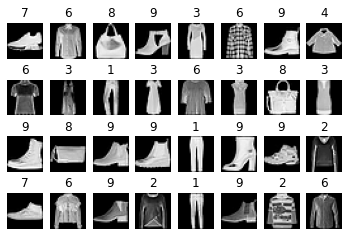

In [6]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

plt.figure()
for i in range(32):
    plt.subplot(4,8,i+1)
    arr=np.squeeze(data)
    plt.imshow(my_sample[0][i][0], cmap='gray')
    plt.axis('off')
    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

## prepare_test_embeddings

In [7]:
def prepare_test_embeddings(dataset_train):
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(dataset_train, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        #x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds)#.detach().cpu().tolist())
        test_targets.extend(y)#.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    accuracy = accuracy_score(test_predictions, test_targets)#,average='micro')
    recall = recall_score(test_predictions, test_targets,average='micro')
    precision = precision_score(test_predictions, test_targets,average='micro')
    f1_score1 = f1_score(test_predictions, test_targets,average='micro')
    
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'precision: {precision*100:.2f}%')
    print(f'recall: {recall*100:.2f}%')
    print(f'f1_score1: {f1_score1*100:.2f}%')
    
    return test_embeddings,test_targets,test_predictions,final_test_acc
#test_embeddings,test_targets,final_test_acc=prepare_test_embeddings(dataset_train)

In [9]:
# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score,accuracy_score
# calculates recall for 1:100 dataset with 90 tp and 10 fn
from sklearn.metrics import recall_score
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score

In [10]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)
_,_,_,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Accuracy: 90.34%
precision: 90.34%
recall: 90.34%
f1_score1: 90.34%
Initial Testing accuracy:   0.9034
